In [1]:
import dgl
import torch
from dgl.data.utils import save_graphs

(g1,), _ = dgl.load_graphs('graph.dgl')
(g2,), _ = dgl.load_graphs('graph2.dgl')
(g3,), _ = dgl.load_graphs('graph3.dgl')


In [2]:
g=g1

In [3]:
g

Graph(num_nodes=2916, num_edges=6642,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'CRS_DEP_TIME': Scheme(shape=(1,), dtype=torch.float32), 'DEP_DELAY': Scheme(shape=(1,), dtype=torch.float32), 'WHEELS_OFF': Scheme(shape=(1,), dtype=torch.float32), 'CRS_ARR_TIME': Scheme(shape=(1,), dtype=torch.float32), 'ARR_DELAY': Scheme(shape=(1,), dtype=torch.float32), 'DEST': Scheme(shape=(1,), dtype=torch.float32), 'ORIGIN': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'AIRCRAFT_NUM': Scheme(shape=(1,), dtype=torch.float32), 'INTERVAL_TIME': Scheme(shape=(1,), dtype=torch.float32), 'AIRPORT': Scheme(shape=(1,), dtype=torch.float32)})

In [4]:
# 检查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('使用设备:', device)

使用设备: cuda


In [6]:
node_features = g.ndata['feat']
node_labels = g.ndata['label']
# 将图，节点特征和节点标签移动到GPU
g = g.to(device)
node_features = node_features.to(device)
node_labels = node_labels.to(device)

In [7]:
print(g.ndata['feat'])
print(g.ndata['label'])

tensor([[  49.,   20., -180.,   38.],
        [  20.,  303., -360.,   15.],
        [ 303.,   37., -300.,    8.],
        ...,
        [ 235.,  166.,  360.,   15.],
        [  64.,  278.,  300.,   14.],
        [  20.,  243.,  -60.,   26.]], device='cuda:0')
tensor([[  6.],
        [ -9.],
        [ -9.],
        ...,
        [-11.],
        [-36.],
        [-13.]], device='cuda:0')


In [8]:
#g.adj()
#g.num_nodes()

tensor(indices=tensor([[   0,    1,    2,  ..., 2914, 2914,    0],
                       [   1,    2,    3,  ..., 1941, 1944, 2915]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(2916, 2916), nnz=6642, layout=torch.sparse_coo)

2916

In [42]:
from sklearn.model_selection import train_test_split

num = g.num_nodes()

indices = np.arange(num)

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_mask = torch.zeros(num, dtype=torch.bool)
test_mask = torch.zeros(num, dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

train_indices, valid_indices = train_test_split(train_indices, test_size=0.2, random_state=42)

valid_mask = torch.zeros(num, dtype=torch.bool)
valid_mask[valid_indices] = True

print("Train mask:", train_mask)
print("Test mask:", test_mask)
print("Valid mask:", valid_mask)

Train mask: tensor([ True,  True,  True,  ...,  True, False, False])
Test mask: tensor([False, False, False,  ..., False,  True,  True])
Valid mask: tensor([False, False,  True,  ..., False, False, False])


In [43]:
n_features = node_features.shape[1]
n_labels = 1
print(n_features)
print(n_labels)

4
1


In [44]:
    # 构建一个2层的GNN模型
    import dgl.nn as dglnn
    import torch.nn as nn
    import torch.nn.functional as F
    class SAGE(nn.Module):
        def __init__(self, in_feats, hid_feats, out_feats):
            super().__init__()
            # 实例化SAGEConve，in_feats是输入特征的维度，out_feats是输出特征的维度，aggregator_type是聚合函数的类型
            self.conv1 = dglnn.SAGEConv(
                in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
            self.conv2 = dglnn.SAGEConv(
                in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')
      
        def forward(self, graph, inputs):
            # 输入是节点的特征
            h = self.conv1(graph, inputs)
            h = F.relu(h)
            h = self.conv2(graph, h)
            return h

In [45]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        pred = model(graph, features)
        pred = logits[mask]
        labels = labels[mask]
        z = torch.cat([labels, pred], dim=1)
        corr = torch.corrcoef(z)
        print(corr)
        return corr

Training took 3.7868492603302 seconds.


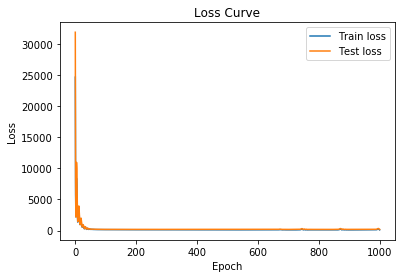

In [89]:
    # 导入matplotlib.pyplot模块
    import matplotlib.pyplot as plt

    loss_list = []
    loss_test_list = []

    import time

    start_time = time.time()
    

    model = SAGE(in_feats=n_features, hid_feats=1000, out_feats=1).to(device)
    opt = torch.optim.Adam(model.parameters())
    
    for epoch in range(1000):
        model.train()
        pred = model(g, node_features)
        loss = F.mse_loss(pred[train_mask], node_labels[train_mask])
        loss_test=F.mse_loss(pred[test_mask],node_labels[test_mask])

        # 进行反向传播计算
        opt.zero_grad()
        loss.backward()
        opt.step()
        #print(loss.item())
        #print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
        #print(loss_test.item())
        # 将损失值添加到列表中
        loss_list.append(loss.item())
        loss_test_list.append(loss_test.item())
        #print(acc)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training took {elapsed_time} seconds.")
    

    loss_train = np.array(loss_list)
    loss_test = np.array(loss_test_list)
    plt.plot(loss_train, label="Train loss")
    plt.plot(loss_test, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.savefig("loss_plot.png", dpi=1000)
    plt.show()

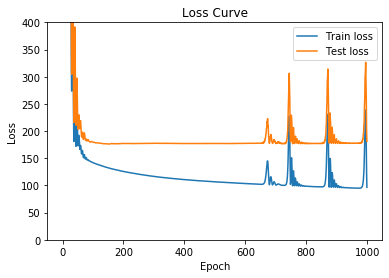

In [90]:
    plt.plot(loss_train, label="Train loss")
    plt.plot(loss_test, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.savefig("loss_plot.png", dpi=1000)
    plt.ylim(0, 400)
    plt.show()